In [1]:
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [2]:
corpus = ['king is a strong man', 
          'queen is a wise woman', 
          'boy is a young man',
          'girl is a young woman',
          'prince is a young king',
          'princess is a young queen',
          'man is strong', 
          'woman is pretty',
          'prince is a boy will be king',
          'princess is a girl will be queen']

stopwords=['is', 'a', 'will', 'be']

In [3]:
def remove_stopwords(corpus,stopwords):
    for i, sent in enumerate(corpus):
        words = sent.split()

        new_sent=[]
        for w in words:
            if (w in stopwords):
                pass
            else:
                new_sent.append(w)

        corpus[i]=' '.join(new_sent)
        
    return corpus

corpus = remove_stopwords(corpus,stopwords)
corpus

['king strong man',
 'queen wise woman',
 'boy young man',
 'girl young woman',
 'prince young king',
 'princess young queen',
 'man strong',
 'woman pretty',
 'prince boy king',
 'princess girl queen']

In [4]:
words = list(map(lambda x:x.split(),corpus))
vocab = set(itertools.chain(*words))

word2int = dict(zip(vocab,range(len(vocab))))
word2int

{'wise': 0,
 'boy': 1,
 'strong': 2,
 'girl': 3,
 'pretty': 4,
 'woman': 5,
 'prince': 6,
 'princess': 7,
 'queen': 8,
 'king': 9,
 'man': 10,
 'young': 11}

In [5]:
WINDOW_SIZE=2

data=[]
for sent in corpus:
    words = sent.split()
    
    for i, w in enumerate(words):
        left = max(0,i-WINDOW_SIZE)
        right = min(len(words)-1,i+WINDOW_SIZE)
        context = words[left:right+1]
        context.remove(w)
        
        data+=list(zip([w]*len(context),context))

In [6]:
data = pd.DataFrame(data,columns=['context','target'])

data.shape

(52, 2)

In [7]:
data.head()

,context,target
0,king,strong
1,king,man
2,strong,king
3,strong,man
4,man,king


In [8]:
data = data.replace(word2int)
data.head()

,context,target
0,9,2
1,9,10
2,2,9
3,2,10
4,10,9


In [9]:
I = np.eye(len(vocab),dtype='float32')

input_data = np.array(list(map(lambda x: I[x], data['context'])))
output_data = np.array(list(map(lambda x: I[x], data['target'])))

input_data.shape, output_data.shape

((52, 12), (52, 12))

In [10]:
X_train, X_test, y_train, y_test = train_test_split(input_data, output_data, test_size=0.05, random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((49, 12), (3, 12), (49, 12), (3, 12))

In [11]:
embedding_dim = 2
output_dim = len(vocab)

class word2vec(Model):
    def __init__(self, embedding_dim, output_dim):
        super(word2vec, self).__init__()
        
        self.embedding_dim = embedding_dim
        self.output_dim = output_dim
        
        self.fc1 = tf.keras.Sequential([layers.Dense(embedding_dim, activation='linear')])
        self.fc2 = tf.keras.Sequential([layers.Dense(output_dim, activation='softmax')])

    def call(self, x):
        embedding = self.fc1(x)
        output = self.fc2(embedding)
        return output

model = word2vec(embedding_dim, output_dim)

In [12]:
model.compile(optimizer='adam', loss=losses.CategoricalCrossentropy())

In [13]:
%%time

history = model.fit(input_data, output_data, epochs=20000, shuffle=True,
                         validation_data=(X_test, y_test), verbose = 0)

Wall time: 13min 8s


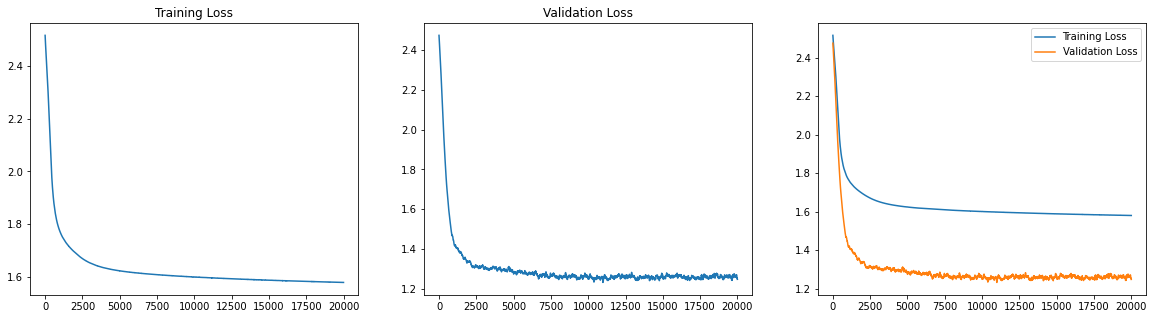

In [14]:
fig=plt.figure(figsize=(20,5))

plt.subplot(131)
plt.plot(history.history["loss"], label="Training Loss")
plt.title('Training Loss')

plt.subplot(132)
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title('Validation Loss')

plt.subplot(133)

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

In [15]:
y_score = model.call(X_test).numpy()
pred_labels = np.argmax(y_score,axis=1)

actual_labels = np.argmax(y_test,axis=1)

accuracy_score(actual_labels, pred_labels)

0.3333333333333333

In [16]:
vectors = model.fc1(I).numpy()

word_vectors=pd.DataFrame(vectors,columns=['x1','x2'])
word_vectors['word']=vocab

word_vectors.head()

,x1,x2,word
0,2.908722,4.284830,wise
1,-0.439288,-1.057792,boy
2,-1.500164,-6.231875,strong
3,0.578401,0.679510,girl
4,12.512035,-4.043598,pretty


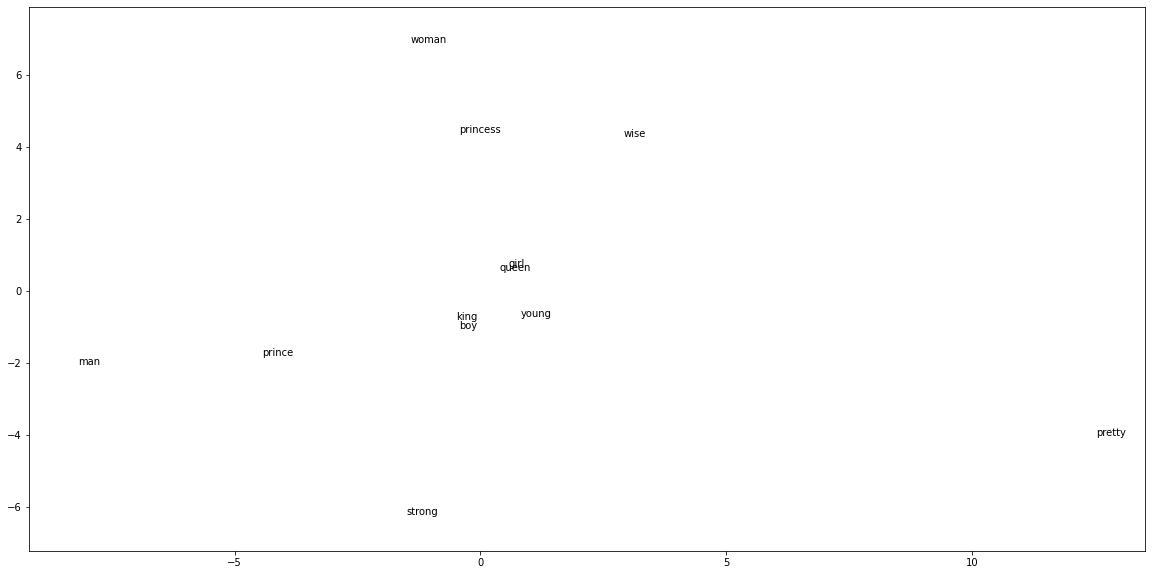

In [17]:
fig, ax = plt.subplots(figsize=(20,10))

for word, x1, x2 in zip(word_vectors['word'], word_vectors['x1'], word_vectors['x2']):
    ax.annotate(word, (x1,x2 ))
    
PADDING = 1.0
x_axis_min = np.amin(vectors, axis=0)[0] - PADDING
y_axis_min = np.amin(vectors, axis=0)[1] - PADDING
x_axis_max = np.amax(vectors, axis=0)[0] + PADDING
y_axis_max = np.amax(vectors, axis=0)[1] + PADDING
 
plt.xlim(x_axis_min,x_axis_max)
plt.ylim(y_axis_min,y_axis_max)
plt.rcParams["figure.figsize"] = (10,10)

plt.show()